In [3]:
import os,sys
%matplotlib inline
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from statannot import add_stat_annotation
from scipy import stats 
import PyComplexHeatmap
from PyComplexHeatmap import *
import warnings
warnings.filterwarnings(action='ignore')
print(matplotlib.__version__)
print(sns.__version__)
print(PyComplexHeatmap.__version__)

3.7.3
0.12.2
1.6.2


# Import data

In [39]:
PPGR_meal_merged = pd.read_csv('../data/PPGR_meal_merged_cont2.csv',index_col=0) #Merged data (meal + CGM)
OTU_data = pd.read_csv('../data/T2D_KBSMC_otu_norm.csv',index_col=0)             #16s microbiome data (taxonomic mapped read count profile)
med_data = pd.read_excel('../data/CGM Nutrition_CRF_Medication.xlsx')            #Medication usage
clinical_data = pd.read_excel('../data/CGM Nutrition_CRF_20230808_추가Lab.xlsx') #Clinicodemograhic data

## Feature engineering & data cleaning

In [40]:
# Calculating PPGR #
CGM_post120_col = [f"p_{t:03d}" for t in range(0,121,5)]
CGM_post240_col = [f"p_{t:03d}" for t in range(0,241,5)]

PPGR_meal_merged[CGM_post240_col] = PPGR_meal_merged.loc[:,CGM_post240_col].interpolate(axis=1) # Fill the Nan with interpolated value

G0 = PPGR_meal_merged['p_000']
# 2h PPGR #
iAUC_2h = [0]*len(PPGR_meal_merged)
for i in range(1,25):
    Gi = PPGR_meal_merged[CGM_post120_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post120_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_2h+=Si*5

# 4h PPGR #
iAUC_4h = [0]*len(PPGR_meal_merged)
for i in range(1,49):
    Gi = PPGR_meal_merged[CGM_post240_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post240_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_4h+=Si*5
    
PPGR_meal_merged['PPGR_u2'] = iAUC_2h/60
PPGR_meal_merged['PPGR_u4'] = iAUC_4h/60

In [42]:
PPGR_meal_merged_filt = PPGR_meal_merged.dropna(subset=['meal_m1'],axis=0)
PPGR_meal_merged_filt = PPGR_meal_merged_filt[(PPGR_meal_merged['Energy(kcal)']<2000) & (PPGR_meal_merged['Carb(g)']<250)]
PPGR_meal_merged_filt['Carb_root'] = PPGR_meal_merged_filt['Carb(g)']**(1/2)
PPGR_meal_merged_filt['Carb_pro'] = PPGR_meal_merged_filt['Carb(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Protein_pro'] = PPGR_meal_merged_filt['Protein(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Fat_pro'] = PPGR_meal_merged_filt['Fat(g)']*9 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100

# microbiome data Box-cox transformation
OTU_data_bc = pd.DataFrame(stats.boxcox(OTU_data,lmbda=0.25),columns=OTU_data.columns,index=OTU_data.index)
# microbiome data selected features
f=pd.read_csv('../features/filter_p0.05_367.csv')  # Selected microbiome species features by filter method
microbiome_col = list(f.loc[:,'feature'])
OTU_data_bc = OTU_data_bc[microbiome_col]
microbiome_col_ = [';'.join(var.split(';')[-2:]) for var in microbiome_col]
OTU_data_bc.columns = microbiome_col_

# Features
CGM_pre30_col = [f"m_{t:03d}" for t in range(30,0,-5)]+['p_000']
meal_composition = ['Carb_root','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)','Carb_pro','Protein_pro','Fat_pro']
meal_context = ['meal_m1','prot_b6h','Time']
cli_col = ['Age','DM_Duration','BMI','HbA1c','SBP','DBP','HDL','LDL','AST(IU/L)','ALT(IU/L)'] 
med_col = ['Basal_Ins_Dose_Unit','MFM_Dose_Total','SU_Dose_Total','DPP4i_Dose_Total','SGLT2i_Dose_Total'] 

# Target features (2h PPGR & 4h PPGR)
PPGR = 'PPGR_u2'
PPGR_4 = 'PPGR_u4'

# Final dataframe
PPGR_data =  PPGR_meal_merged_filt.dropna(subset=['PPGR_u2','PPGR_u4']+CGM_pre30_col,axis=0)
full_data = pd.merge(PPGR_data[['ID','Dname',PPGR,PPGR_4,'Carb(g)','Meal']+CGM_pre30_col+CGM_post240_col+meal_composition+meal_context],OTU_data_bc[microbiome_col_],left_on='ID',right_index=True)
full_data = full_data.T.drop_duplicates().T
full_data = pd.merge(full_data,med_data,how='left',on='ID')
full_data = pd.merge(full_data,clinical_data,how='left',on='ID')
full_data[PPGR] = full_data[PPGR].astype(float)
full_data[PPGR_4] = full_data[PPGR_4].astype(float)

samples = list(full_data['ID'].unique())
full_data

,ID,Dname,PPGR_u2,PPGR_u4,Carb(g),Meal,m_030,m_025,m_020,m_015,...,TG,HDL,LDL,MDRD_eGFR,C_pep,C-peptide_index,HOMA IR (C-peptide),HR(bpm),AST(IU/L),ALT(IU/L)
0,R01,사과,114.625000,244.666667,5.75,5,131.0,135.0,135.0,131.0,...,315,32,44,86.1,1.7,4.612802,0.192700,91.5,24,39
1,R01,과일샐러드귀리흰우유,26.666667,-24.791667,60.295,1,130.0,136.0,141.0,144.0,...,315,32,44,86.1,1.7,4.612802,0.192700,91.5,24,39
2,R01,고사리나물더덕구이도토리묵무침두부된장국땅콩조림무말랭이무침배추김치숙주나물시금치나물쌀밥오...,141.750000,217.750000,136.5433,2,119.0,118.0,117.0,116.0,...,315,32,44,86.1,1.7,4.612802,0.192700,91.5,24,39
3,R01,라면사과회냉면,208.458333,414.458333,175.816,3,85.0,85.0,87.0,90.0,...,315,32,44,86.1,1.7,4.612802,0.192700,91.5,24,39
4,R01,계란:전란:삶은것국밥깍두기,168.083333,193.666667,84.41,1,104.0,101.0,99.0,98.0,...,315,32,44,86.1,1.7,4.612802,0.192700,91.5,24,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,R50,쇠고기덮밥,60.583333,169.875000,78.797,2,190.0,186.0,181.0,175.0,...,155,45,68,107.7,1.2,5.432546,0.163623,94.0,19,21
907,R50,상추소고기 구이(등심)쌀밥,24.458333,116.250000,54.26,3,188.0,187.0,186.0,185.0,...,155,45,68,107.7,1.2,5.432546,0.163623,94.0,19,21
908,R50,감자채볶음고추멸치볶음쌀밥열무김치,-4.875000,217.458333,73.6332,1,162.0,162.0,163.0,164.0,...,155,45,68,107.7,1.2,5.432546,0.163623,94.0,19,21
909,R50,장어매운탕,-40.250000,-61.000000,38.04943,2,226.0,224.0,222.0,222.0,...,155,45,68,107.7,1.2,5.432546,0.163623,94.0,19,21


In [43]:
# Import Evaluation data processed with same procedure
evaluation_data = pd.read_csv('../data/PPGR_meal_merged_validation_nonbc.csv',index_col=0)
evaluation_data = evaluation_data.rename(columns = dict(zip(microbiome_col,microbiome_col_)))
evaluation_data

,ID,PPGR_u2,PPGR_u4,Carb(g),m_240,m_235,m_230,m_225,m_220,m_215,...,Bacteria;Fusobacteria;Fusobacteria_c;Fusobacteriales;Fusobacteriaceae;Fusobacterium;Fusobacterium_necrogenes_group,Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;Slackia;Slackia_isoflavoniconvertens,Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;NHOC_g;PAC001240_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Anaerotignum;PAC002392_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Sporobacter;EU779114_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;PAC000195_g;DQ801499_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Acetitomaculum;PAC001448_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Coprococcus_g2;EF640143_s,Bacteria;Firmicutes;Clostridia;Clostridiales;Christensenellaceae;PAC001207_g;PAC002323_s,Bacteria;Firmicutes;Clostridia;Natranaerobiales;Dethiobacter_f;EF585983_g;EF585983_g_uc
0,C0001,-37.500000,10.458333,10.00,130.0,128.0,129.0,126.0,123.0,122.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,C0001,-38.583333,-135.500000,77.00,179.0,175.0,167.0,160.0,159.0,156.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,C0001,121.250000,177.416667,50.45,84.0,82.0,78.0,75.0,73.0,73.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,C0001,103.333333,368.458333,97.08,99.0,103.0,102.0,99.0,98.0,94.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,C0001,64.458333,195.875000,3.66,246.0,253.0,253.0,255.0,257.0,246.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,C0051,35.291667,49.250000,83.15,122.0,125.0,128.0,124.0,124.0,126.0,...,0.0,0.0,0.006626,0.0,0.0,0.000061,0.0,0.0,0.0,0.0
1244,C0051,80.750000,154.000000,72.79,130.0,130.0,140.0,148.0,151.0,159.0,...,0.0,0.0,0.006626,0.0,0.0,0.000061,0.0,0.0,0.0,0.0
1245,C0051,-30.875000,-93.125000,14.10,201.0,198.0,197.0,194.0,191.0,190.0,...,0.0,0.0,0.006626,0.0,0.0,0.000061,0.0,0.0,0.0,0.0
1246,C0051,54.125000,112.833333,21.94,169.0,175.0,174.0,169.0,166.0,165.0,...,0.0,0.0,0.006626,0.0,0.0,0.000061,0.0,0.0,0.0,0.0


# Basic Characteristics of population

In [44]:
# Characteristics of study population
metadata_filt = clinical_data[clinical_data['ID'].isin(samples)]
evaluation_clinical_data = evaluation_data.drop_duplicates('ID')
continuous_var = ['Age','DM_Duration','BMI','Weight(kg)','Waist_Circumference(cm)','SBP','DBP','FBS','HbA1c','Total_chol','TG',
                  'HDL','LDL','MDRD_eGFR','C_pep','C-peptide_index','HOMA IR (C-peptide)','HR(bpm)','AST(IU/L)','ALT(IU/L)']

cont_var_df = pd.DataFrame(columns=['var'])
for i, var in enumerate(continuous_var):
    cont_var_df.loc[i,'var'] = var
    cont_var_df.loc[i,'Main'] = str(np.round(np.mean(metadata_filt[var]),1))+' ± '+str(np.round(np.std(metadata_filt[var]),2))
    cont_var_df.loc[i,'Evaluation'] = str(np.round(np.mean(evaluation_clinical_data[var]),1))+' ± '+str(np.round(np.std(evaluation_clinical_data[var]),2))
    #t-test
    res = stats.ttest_ind(metadata_filt[var],evaluation_clinical_data[var])#.dropna(subset=var)
    cont_var_df.loc[i,'p-value'] = res.pvalue
cont_var_df

,var,Main,Evaluation,p-value
0,Age,64.5 ± 7.86,56.9 ± 7.09,1.307066e-05
1,DM_Duration,17.5 ± 8.01,10.8 ± 6.6,7.957904e-05
2,BMI,25.6 ± 3.0,24.6 ± 3.84,1.980710e-01
3,Weight(kg),67.4 ± 11.46,68.0 ± 14.49,8.252172e-01
4,Waist_Circumference(cm),90.6 ± 7.91,85.8 ± 9.74,1.423655e-02
5,SBP,125.0 ± 11.82,121.0 ± 11.68,1.212573e-01
6,DBP,75.4 ± 8.06,71.1 ± 8.85,2.118980e-02
7,FBS,148.4 ± 32.57,132.5 ± 26.36,1.601898e-02
8,HbA1c,7.9 ± 0.5,7.2 ± 0.58,3.788591e-08
9,Total_chol,142.6 ± 23.67,134.8 ± 24.19,1.355286e-01


In [47]:
# Characteristics of meal
macronutrient_var = ['Energy(kcal)','Carb(g)','Protein(g)','Fat(g)','Fiber(g)','Carb_pro','Protein_pro','Fat_pro']

macro_var_df = pd.DataFrame(columns=['var'])
for i, var in enumerate(macronutrient_var):
    macro_var_df.loc[i,'var'] = var
    macro_var_df.loc[i,'Main'] = str(np.round(np.mean(full_data[var]),1))+' ± '+str(np.round(np.std(full_data[var]),2))
    macro_var_df.loc[i,'Evaluation'] = str(np.round(np.mean(evaluation_data[var]),1))+' ± '+str(np.round(np.std(evaluation_data[var]),2))
    #t-test
    res = stats.ttest_ind(full_data[var].astype(float),evaluation_data[var])
    macro_var_df.loc[i,'p-value'] = res.pvalue
macro_var_df

,var,Main,Evaluation,p-value
0,Energy(kcal),475.8 ± 285.47,440.3 ± 312.74,6.987422e-03
1,Carb(g),70.2 ± 41.55,61.9 ± 45.22,1.462610e-05
2,Protein(g),19.3 ± 15.88,18.7 ± 15.83,3.425211e-01
3,Fat(g),12.4 ± 11.73,12.5 ± 13.0,8.029416e-01
4,Fiber(g),8.0 ± 5.79,4.7 ± 6.55,6.758258e-33
5,Carb_pro,62.4 ± 19.14,59.5 ± 21.14,1.038117e-03
6,Protein_pro,15.6 ± 7.85,16.1 ± 9.19,2.096551e-01
7,Fat_pro,21.9 ± 15.12,24.4 ± 16.49,4.584038e-04


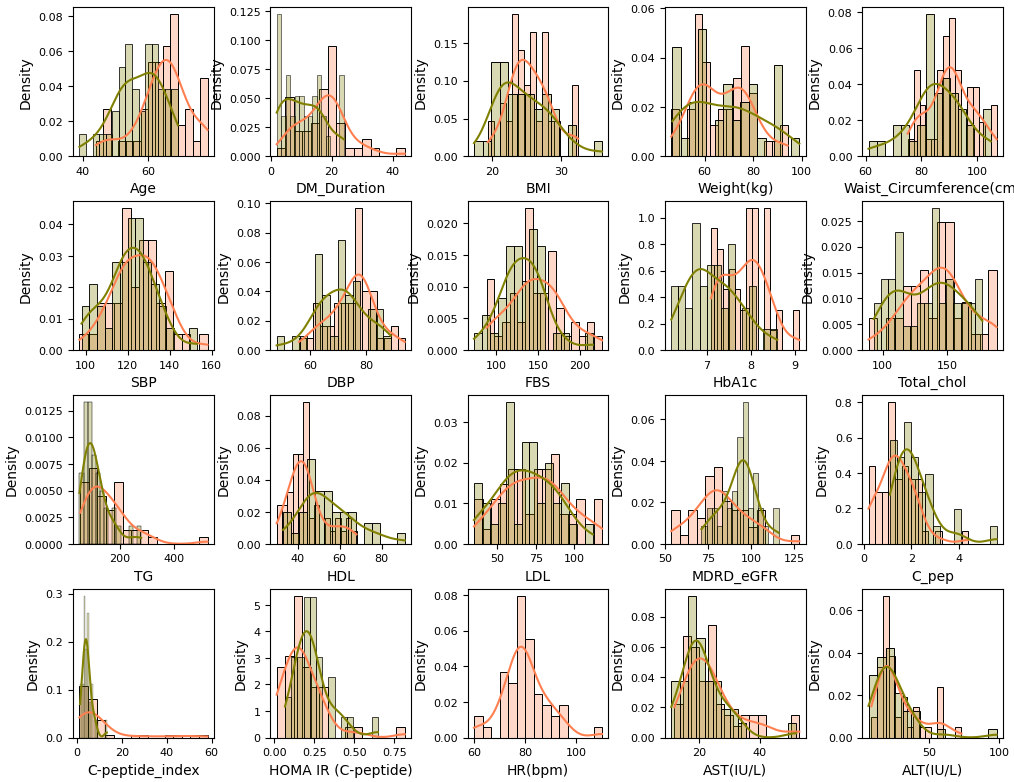

In [45]:
plt.figure(figsize=(12,12))

for i, var in enumerate(continuous_var):
    ax = plt.subplot(5,5,i+1)
    ax = sns.histplot(data = metadata_filt,x=var,bins=15,stat='density',color='coral',alpha=0.3,kde=True)
    ax = sns.histplot(data = evaluation_clinical_data,x=var,bins=15,stat='density',color='olive',alpha=0.3,kde=True)
    ax.tick_params(axis="both", labelsize=8) 

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

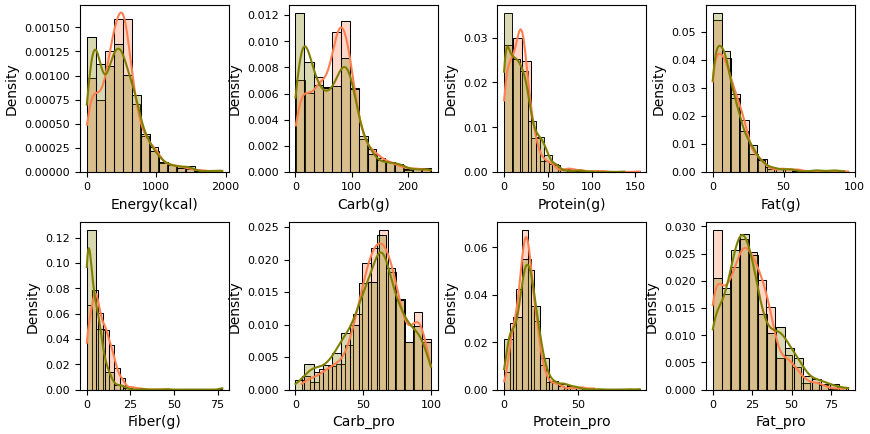

In [48]:
plt.figure(figsize=(10,5))

for i, var in enumerate(macronutrient_var):
    ax = plt.subplot(2,4,i+1)
    ax = sns.histplot(data = full_data,x=var,bins=15,stat='density',color='coral',alpha=0.3,kde=True)
    ax = sns.histplot(data = evaluation_data,x=var,bins=15,stat='density',color='olive',alpha=0.3,kde=True)
    ax.tick_params(axis="both", labelsize=8) 

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

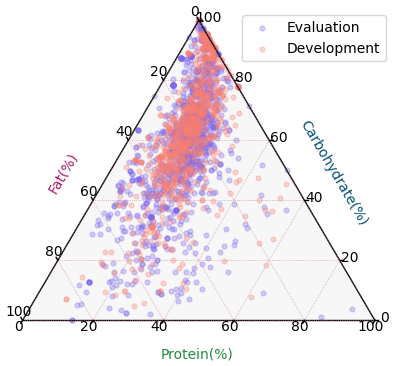

In [58]:
import ternary

fig, tax = ternary.figure(scale=100)
fig.set_size_inches(5, 4.5)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=20)

tax.scatter(evaluation_data[['Protein_pro','Carb_pro','Fat_pro']].values,s=12,alpha=0.3,c="mediumslateblue",label='Evaluation')
tax.scatter(full_data[['Protein_pro','Carb_pro','Fat_pro']].values,s=12,alpha=0.3,c="salmon",label='Development')

tax.ticks(axis='lbr', linewidth=1, multiple=20)
tax.bottom_axis_label("Protein(%)", fontsize=10,color='#228B3B')
tax.right_axis_label("Carbohydrate(%)", fontsize=10,offset=0.14,color='#045275')
tax.left_axis_label("Fat(%)", fontsize=10,offset=0.14,color='#AB1866')
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.legend()
#tax.savefig('../figure/ternary_macronutrient_main_eval.jpeg')

tax.show()

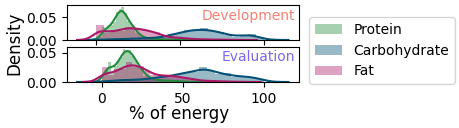

In [59]:
data=full_data
fig,ax = plt.subplots(2,1,figsize=(3,1))
sns.distplot(data['Protein_pro'],label='Protein',color='#228B3B',ax=ax[0])
sns.distplot(data['Carb_pro'],label='Carbohydrate',color='#045275',ax=ax[0])
sns.distplot(data['Fat_pro'],label='Fat',color='#AB1866',ax=ax[0])
ax[0].text(63,0.045,'Development',color='salmon')
data=evaluation_data
sns.distplot(data['Protein_pro'],label='Protein',color='#228B3B',ax=ax[1])
sns.distplot(data['Carb_pro'],label='Carbohydrate',color='#045275',ax=ax[1])
sns.distplot(data['Fat_pro'],label='Fat',color='#AB1866',ax=ax[1])
ax[1].text(74,0.035,'Evaluation',color='mediumslateblue')
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
fig.supxlabel('% of energy',y=-0.3)
fig.supylabel('Density', x=-0.08)
plt.legend(loc='right',bbox_to_anchor=(1.7, 0.9))
#plt.savefig('../figure/energy_proportion_main_eval.jpeg',dpi=300)
plt.show()

# Risk factor analysis
## Clinical variables vs simulated standardized PPGR

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


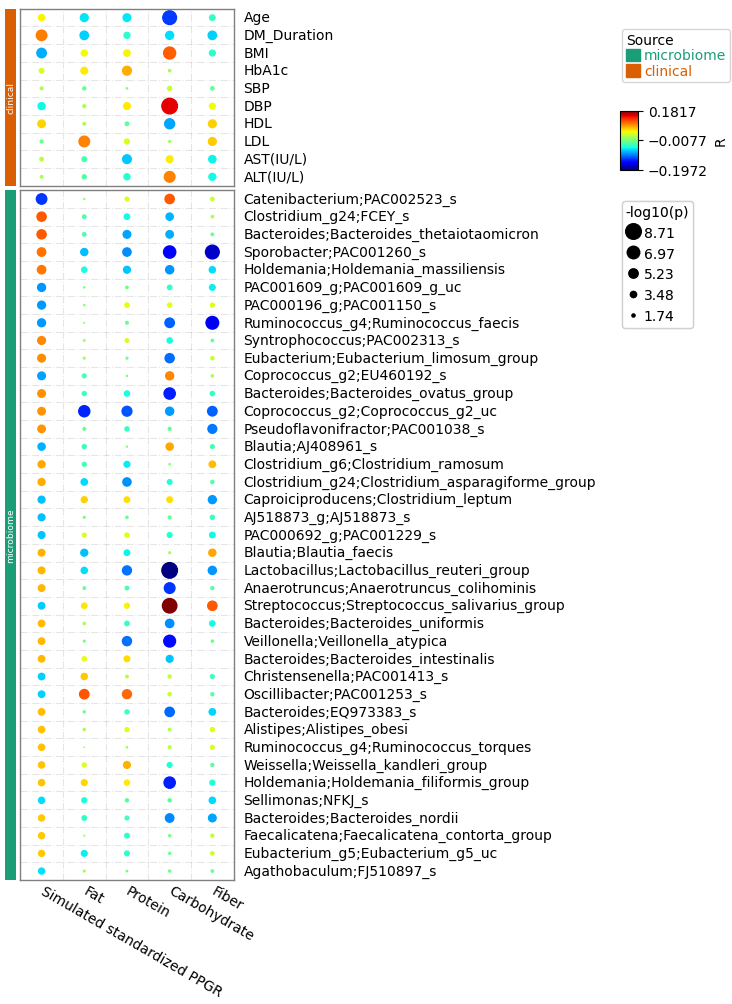

In [51]:
carb_r_list,carb_p_list=[],[]
fat_r_list,fat_p_list=[],[]
fiber_r_list,fiber_p_list=[],[]
protein_r_list,protein_p_list=[],[]
simul_PPGR_r_list, simul_PPGR_p_list = [],[]
source = ['clinical']*len(cli_col) + ['microbiome']*len(microbiome_col_)
## simulated PPGR#
X_main = full_data[PPGR]/full_data['Carb(g)'].astype(float)
q1_main = X_main.quantile(0.25)
q3_main = X_main.quantile(0.75)
IQR_main = q3_main-q1_main
dff_main = X_main[(X_main<=q3_main + (3*IQR_main)) & (X_main>=q1_main-(3*IQR_main))]
X_main = dff_main

# 결과를 저장할 리스트 초기화
results = []  
for i, var in enumerate(cli_col+microbiome_col_):
    carb_r,carb_p = stats.pearsonr(full_data['Carb(g)'],full_data[var].astype(float))
    fat_r,fat_p = stats.pearsonr(full_data['Fat(g)'],full_data[var].astype(float))
    fiber_r,fiber_p = stats.pearsonr(full_data['Fiber(g)'],full_data[var].astype(float))
    protein_r,protein_p = stats.pearsonr(full_data['Protein(g)'],full_data[var].astype(float))
    simul_r,simul_p = stats.pearsonr(X_main,full_data[var][dff_main.index].astype(float))

    # 결과를 리스트에 추가
    results.append({'variable': var, 'R': carb_r, 'p value': carb_p, 'target': 'Carbohydrate', 'source': source[i]})
    results.append({'variable': var, 'R': fat_r, 'p value': fat_p, 'target': 'Fat', 'source': source[i]})
    results.append({'variable': var, 'R': fiber_r, 'p value': fiber_p, 'target': 'Fiber', 'source': source[i]})
    results.append({'variable': var, 'R': protein_r, 'p value': protein_p, 'target': 'Protein', 'source': source[i]})
    results.append({'variable': var, 'R': simul_r, 'p value': simul_p, 'target': 'Simulated standardized PPGR', 'source': source[i]})

cont_var_df = pd.DataFrame(results)

cont_var_df['-log10(p)'] = -np.log10(cont_var_df['p value'])
plt.figure(figsize=(3,10))

left_ha  = HeatmapAnnotation(Source=anno_simple(cont_var_df.drop_duplicates('variable').set_index('variable')['source'],legend=True,cmap='Dark2',add_text=True),
                           axis=0,label_kws={'visible':False,'fontsize':10})
cm = DotClustermapPlotter(data=cont_var_df, y='variable',x='target',value='R',c='R',s='-log10(p)',show_rownames=True,show_colnames=True,col_names_side='bottom',
                          row_dendrogram=False,row_cluster=False, row_split=cont_var_df.drop_duplicates('variable').set_index('variable')['source'], row_split_gap=1,
                          xticklabels_kws={'labelrotation': -30, 'labelsize':10},left_annotation=left_ha,legend_hpad=-2)

for ax in cm.heatmap_axes.ravel():
    ax.grid(axis='both',which='minor',color='black',linestyle='dashdot',alpha=0.1) # which can also be set to major
    for side in ["top", "left", "bottom",'right']: # to show the spines
         ax.spines[side].set_visible(True)
         ax.spines[side].set_color('grey')
         ax.spines[side].set_linewidth(1)
         ax.spines[side].set_linestyle('-')

#plt.savefig('../figure/personal_variable_PPGR2h_corr_dot.jpeg',dpi=300,bbox_inches='tight')
plt.show()

## Nutritional factors vs PPGR

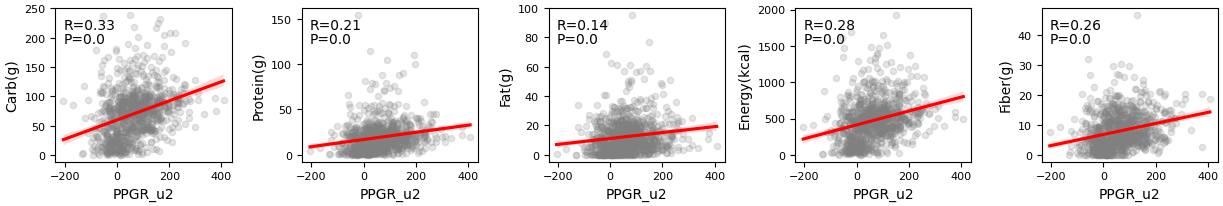

In [52]:
#full_data = full_data.rename(columns={'Meal':'Meal_type'})
data = full_data

meal_R_list = []
meal_P_list = []
plt.figure(figsize=(15,2))
var_list =['Carb(g)','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)']
data[var_list] = data[var_list].astype(float)
for i, var in enumerate(var_list):
    r,p = stats.pearsonr(data[PPGR],data[var])
    meal_R_list.append(r)
    ax = plt.subplot(1,5,i+1)

    if 0.01<p<=0.05:
        color='red'
        meal_P_list.append(' * ')
    elif 0.001<p<=0.01:
        color='red'
        meal_P_list.append(' **')
    elif p<=0.001:
        color='red'
        meal_P_list.append('***')
    else:
        color='skyblue'
        meal_P_list.append('')
    sns.regplot(data = data,x=PPGR,y=var,ax=ax,scatter_kws={"fc":"gray", "ec":"gray", "s":20, "alpha":0.2},color=color)
    ax.tick_params(axis="both", labelsize=8) 
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.9+data[var].min(),f'R={np.round(r,2)}')
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.8+data[var].min(),f'P={np.round(p,2)}')

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

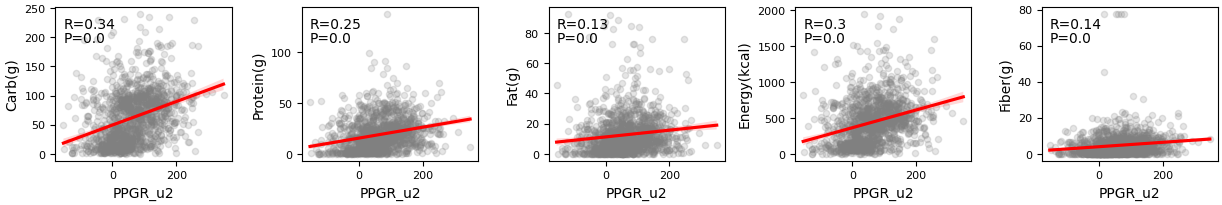

In [53]:
data = evaluation_data

meal_R_list_eval = []
meal_P_list_eval = []
plt.figure(figsize=(15,2))
var_list =['Carb(g)','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)']
data[var_list] = data[var_list].astype(float)
for i, var in enumerate(var_list):
    r,p = stats.pearsonr(data[PPGR],data[var])
    meal_R_list_eval.append(r)
    ax = plt.subplot(1,5,i+1)

    if 0.01<p<=0.05:
        color='red'
        meal_P_list_eval.append(' * ')
    elif 0.001<p<=0.01:
        color='red'
        meal_P_list_eval.append(' **')
    elif p<=0.001:
        color='red'
        meal_P_list_eval.append('***')
    else:
        color='skyblue'
        meal_P_list_eval.append('')
    sns.regplot(data = data,x=PPGR,y=var,ax=ax,scatter_kws={"fc":"gray", "ec":"gray", "s":20, "alpha":0.2},color=color)
    ax.tick_params(axis="both", labelsize=8) 
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.9+data[var].min(),f'R={np.round(r,2)}')
    ax.text(data[PPGR].min(),(data[var].max()-data[var].min())*0.8+data[var].min(),f'P={np.round(p,2)}')

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()

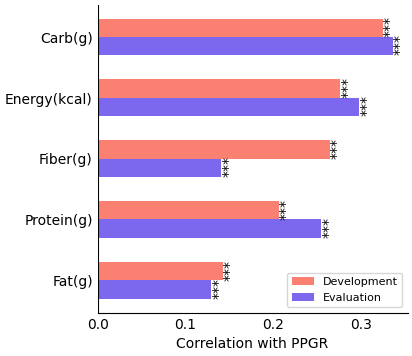

In [54]:
meal_var_df_2h = pd.DataFrame({'var':var_list,'Development':meal_R_list,'Evaluation':meal_R_list_eval,'Main_p':meal_P_list,'Evaluation_p':meal_P_list_eval}).sort_values('Development')
index = np.arange(len(meal_var_df_2h))
plt.figure(figsize=(4,4))
p1=plt.barh(data=meal_var_df_2h,y=index+0.15,width='Development',color="salmon",height=0.3,label='Development')
p2=plt.barh(data=meal_var_df_2h,y=index-0.15,width='Evaluation',color="mediumslateblue",height=0.3,label='Evaluation')
plt.axvline(x=0,color='black')
for i,p in enumerate(meal_var_df_2h['Main_p']):
    plt.text(x=meal_var_df_2h.iloc[i,1],y=i+0.05,s=p,rotation=90)
for i,p in enumerate(meal_var_df_2h['Evaluation_p']):
    plt.text(x=meal_var_df_2h.iloc[i,2],y=i-0.25,s=p,rotation=90)
ax = plt.gca()
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(axis='both', length=0)
plt.xlabel('Correlation with PPGR')
plt.yticks(index,meal_var_df_2h['var'])
plt.legend((p1[0], p2[0]), ('Development', 'Evaluation'),fontsize=8)
#plt.savefig('../figure/meal_variable_PPGR2h_corr.jpeg',dpi=300,bbox_inches='tight')
plt.show()

## Meal timing & PPGR

<Figure size 1200x1000 with 0 Axes>

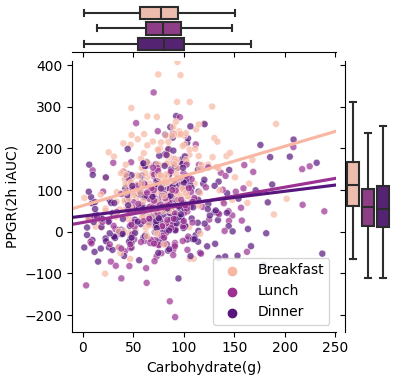

In [55]:
plt.figure(figsize=(12,10))
main_meal = full_data[full_data['Meal'].isin([1,2,3])]
main_meal['Meal'] = main_meal['Meal'].astype(str)
main_meal[PPGR] = main_meal[PPGR].astype(float)
sns.set_palette(sns.color_palette(['#F7B7A3','#9B3192','#57167E']))
g=sns.JointGrid(data=main_meal,x='Carb(g)',y=PPGR, hue='Meal',palette=sns.color_palette(['#F7B7A3','#9B3192','#57167E']),height=4)#,height=4)
sns.boxplot(data=main_meal, x=g.hue, y=g.y, ax=g.ax_marg_y,showfliers = False)
sns.boxplot(data=main_meal, y=g.hue, x=g.x, ax=g.ax_marg_x,showfliers = False)
g.plot_joint(sns.scatterplot,s=25,alpha=0.7)

for _,gr in main_meal.groupby('Meal'):
    sns.regplot(x='Carb(g)', y=PPGR, data=gr, scatter=False, ax=g.ax_joint, truncate=False,ci=None)

#
#plt.xlim(-5,250)
plt.ylim(-240,410)
g.set_axis_labels(xlabel='Carbohydrate(g)',ylabel='PPGR(2h iAUC)')

sns.move_legend(g.ax_joint, "lower right", title='', frameon=True)
texts = g.ax_joint.legend_.texts
for t, label in zip(texts, ['Breakfast','Lunch','Dinner']):
    t.set_text(label)
#plt.savefig('../figure/meal_type_joint_main.jpeg',dpi=300)

<Figure size 300x300 with 0 Axes>

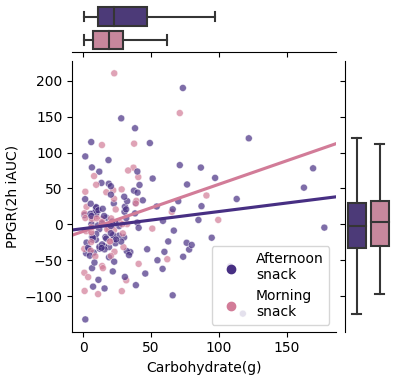

In [56]:
plt.figure(figsize=(3,3))
snack_meal = full_data[full_data['Meal'].isin([4,5])]
snack_meal['Meal'] = snack_meal['Meal'].astype(str)
snack_meal[PPGR] = snack_meal[PPGR].astype(float)
sns.set_palette(sns.color_palette(['#D27C98','#472F83']))
g=sns.JointGrid(data=snack_meal,x='Carb(g)',y=PPGR, hue='Meal',palette=sns.color_palette(['#472F83','#D27C98']),height=4)
sns.boxplot(data=snack_meal, x=g.hue, y=g.y, ax=g.ax_marg_y,showfliers = False,palette=sns.color_palette(['#472F83','#D27C98']))
sns.boxplot(data=snack_meal, y=g.hue, x=g.x, ax=g.ax_marg_x,showfliers = False,palette=sns.color_palette(['#472F83','#D27C98']))
g.plot_joint(sns.scatterplot,s=25,alpha=0.7)

for _,gr in snack_meal.groupby('Meal'):
    sns.regplot(x='Carb(g)', y=PPGR, data=gr, scatter=False, ax=g.ax_joint, truncate=False,ci=None)

g.set_axis_labels(xlabel='Carbohydrate(g)',ylabel='PPGR(2h iAUC)')
sns.move_legend(g.ax_joint, "lower right", title='', frameon=True)

texts = g.ax_joint.legend_.texts
for t, label in zip(texts, ['Afternoon\nsnack','Morning\nsnack']):
    t.set_text(label)
#plt.savefig('../figure/meal_type_joint_snack.jpeg',dpi=300)

# Carbohydrate response subgroup analysis

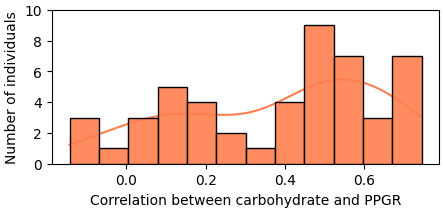

In [63]:
# Carbohydrate responsivity = Pearson's correlation between carbohydrate and 2h PPGR
samples = list(full_data['ID'].unique())
carb_sensitivity = []
carb_sensitivity_p = []
for sample in samples:
    data = full_data[full_data['ID']==sample]
    r,p = stats.pearsonr(data['Carb(g)'],data[PPGR])
    carb_sensitivity.append(r)
    carb_sensitivity_p.append(p)
mean_carb_sen = np.mean(carb_sensitivity)

fig, ax = plt.subplots(figsize=(5,2))
ax = sns.histplot(carb_sensitivity,bins=12,color='coral',zorder=3,alpha=0.9,kde=True)

plt.xlabel("Correlation between carbohydrate and PPGR")
plt.ylabel("Number of individuals")
plt.ylim(0,10)
plt.show()

## Subgroups

In [64]:
# Dividing subgroups
## Carbohydrate responsivity p value <= 0.05 --> high responder
## Carbohydrate responsivity p value > 0.05 --> low responder
samples = list(full_data['ID'].unique())
carb_sensitivity_df = pd.DataFrame({'ID':samples,'R':carb_sensitivity,'p':carb_sensitivity_p})
carb_sensitivity_df.loc[carb_sensitivity_df['p']<=0.05,'carb_sen']='high responder'
carb_sensitivity_df.loc[carb_sensitivity_df['p']>0.05,'carb_sen']='low responder'
carb_sensitivity_df['carb_sen'].value_counts()

carb_sen
low responder     27
high responder    22
Name: count, dtype: int64

## Blood glucose difference

In [65]:
def plot_CGM(data,target,ax,y_ticks_on=True,title=None,color='dimgrey'):
    sen = data[data['carb_sen']==target]

    ax.set_ylim(50,420)
    ax.plot(sen[CGM_post120_col].T,color="#BFBFBF",  lw=1,alpha=0.3)#BFBFBF
    if y_ticks_on==False:
        ax.set_yticks([])
        mean_label=None
        median_label=None
    else:
        ax.set_yticks([100,200,300,400])
        ax.set_yticklabels([100,200,300,400] )
    CGM_post120_col_skip = [col for i,col in enumerate(CGM_post120_col) if i%4==0]
    ax.errorbar(x=CGM_post120_col_skip,y=sen[CGM_post120_col_skip].mean(axis=0), yerr=sen[CGM_post120_col_skip].std(axis=0),marker='o', markersize=8, color=color,markeredgecolor=color,lw=1.5)

    ax.tick_params(bottom=False)
    ax.set_frame_on(False)
    
    ax.set_xticks(['p_000','p_020','p_040','p_060','p_080','p_100','p_120'])
    ax.set_xticklabels(['0','20','40','60','80','100','120'])

    ax.set_title(title,fontsize=10,y=0.9)

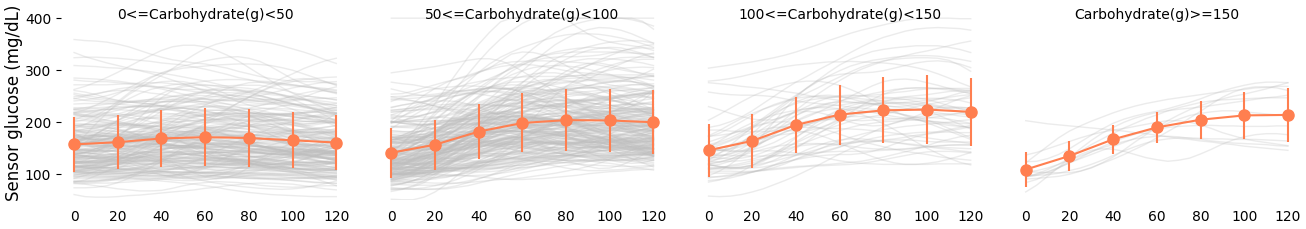

In [66]:
full_data2 = pd.merge(full_data,carb_sensitivity_df,on='ID',how='left')

carb_0_50 = full_data2[(full_data2['Carb(g)']<50) & (full_data2['Carb(g)']>=0)]
carb_50_100 = full_data2[(full_data2['Carb(g)']<100) & (full_data2['Carb(g)']>=50)]
carb_100_150 = full_data2[(full_data2['Carb(g)']<150) & (full_data2['Carb(g)']>=100)]
carb_150 = full_data2[full_data2['Carb(g)']>=150]
titles = ['0<=Carbohydrate(g)<50','50<=Carbohydrate(g)<100','100<=Carbohydrate(g)<150','Carbohydrate(g)>=150']
fig, ax = plt.subplots(1,4,figsize=(16, 2.5))
plot_CGM(carb_0_50,'high responder',ax[0],True,titles[0],color='coral')
plot_CGM(carb_50_100,'high responder',ax[1],False,titles[1],color='coral')
plot_CGM(carb_100_150,'high responder',ax[2],False,titles[2],color='coral')
plot_CGM(carb_150,'high responder',ax[3],False,titles[3],color='coral')

fig.supylabel('Sensor glucose (mg/dL)',x=0.09)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('../figure/2hPPGR_lineplot_eval_high.jpeg',dpi=300, bbox_inches='tight')
plt.show()

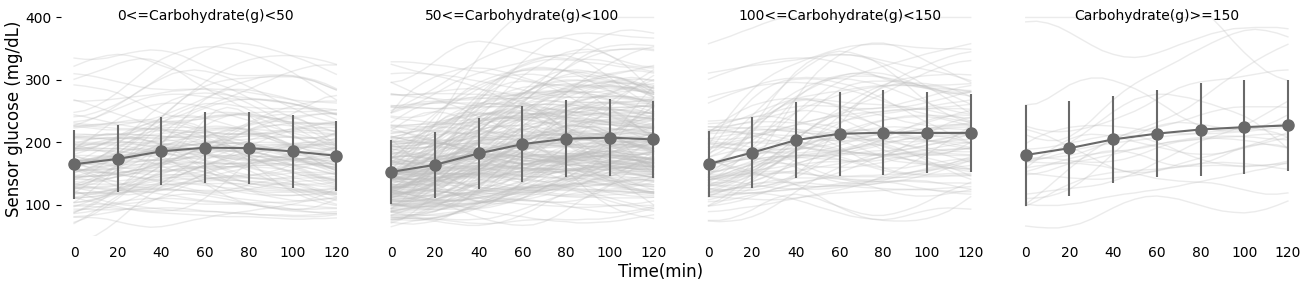

In [68]:
fig, ax = plt.subplots(1,4,figsize=(16, 3))
plot_CGM(carb_0_50,'low responder',ax[0],True,titles[0])
plot_CGM(carb_50_100,'low responder',ax[1],False,titles[1])
plot_CGM(carb_100_150,'low responder',ax[2],False,titles[2])
plot_CGM(carb_150,'low responder',ax[3],False,titles[3])

fig.supxlabel('Time(min)',y=-0.04)
fig.supylabel('Sensor glucose (mg/dL)',x=0.09)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('../figure/2hPPGR_lineplot_eval_low.jpeg',dpi=300, bbox_inches='tight')
plt.show()

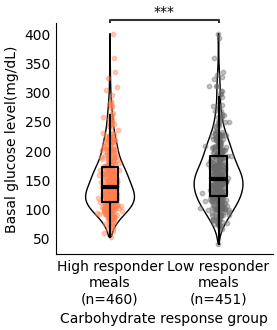

In [71]:
# Basal glucose level
full_data2['p_000'] = full_data2['p_000'].astype(float)
y_data = [full_data2[full_data2["carb_sen"] == type_]['p_000'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["coral", "dimgrey"]

fig, ax = plt.subplots(figsize= (2.8, 3))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("Basal glucose level(mg/dL)", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('black')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="black",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="black"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 10, color=color, alpha=0.4)
    
add_stat_annotation(ax, data=full_data2,x='carb_sen',y='p_000',test='t-test_ind',box_pairs=[('high responder','low responder')], text_offset=1,
                            line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=0, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder\nmeals','Low responder\nmeals'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate response group", size=10)
#plt.savefig('../figure/HbA1c_carb_sen.jpeg',dpi=300,bbox_inches='tight')
plt.show()

In [72]:
# Hyperglycemia
full_data2['glycemia_status'] = full_data2['p_120'].apply(lambda x: 'hyperglycemia' if x > 200 else 'normal')
contingency_table = pd.crosstab(full_data2['carb_sen'], full_data2['glycemia_status'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f'Chi2: {chi2}, p-value: {p}')

Chi2: 10.765704386856367, p-value: 0.001033982059174676


## Clinical data difference

In [73]:
med_var = ['Basal_Ins_Use','MFM_Use','GLP1_Use','SU_Use','DPP4i_Use','SGLT2i_Use','TZD_Use']

carb_sensitivity_clinical_df = pd.merge(clinical_data,med_data[['ID']+med_var],on='ID')
carb_sensitivity_clinical_df = pd.merge(carb_sensitivity_clinical_df,carb_sensitivity_df,on='ID')

high = carb_sensitivity_clinical_df[carb_sensitivity_clinical_df['carb_sen']=='high responder']
low = carb_sensitivity_clinical_df[carb_sensitivity_clinical_df['carb_sen']=='low responder']
category_var = ['Sex','Insulin_use(Basal)','BP_med','Dyslipidemia_med','HTN','Dyslipidemia']
cpep_var = ['C_pep','C-peptide_index','HOMA IR (C-peptide)']
diversity_var = ['shannon','simpson']

for col in continuous_var:
    res = stats.ttest_ind(high[col],low[col],equal_var=True)
    print(col)
    print(res)
    print()
print('-----')
for col in med_var:
    pivot = carb_sensitivity_clinical_df.pivot_table(index='carb_sen',columns=col,aggfunc='size')
    res = stats.chi2_contingency(pivot)
    print(col)
    print(res)
    print()

Age
TtestResult(statistic=0.170871453031674, pvalue=0.8650583428254295, df=47.0)

DM_Duration
TtestResult(statistic=0.7655609820437734, pvalue=0.44776514644989085, df=47.0)

BMI
TtestResult(statistic=-0.36728351761905287, pvalue=0.7150562068721944, df=47.0)

Weight(kg)
TtestResult(statistic=0.27557912982245314, pvalue=0.7840793587326835, df=47.0)

Waist_Circumference(cm)
TtestResult(statistic=-0.325453318583897, pvalue=0.7462824809199361, df=47.0)

SBP
TtestResult(statistic=0.07259294520460975, pvalue=0.9424380926172293, df=47.0)

DBP
TtestResult(statistic=-0.6162920014229706, pvalue=0.5406754423944338, df=47.0)

FBS
TtestResult(statistic=-0.4838209811130723, pvalue=0.6307596207460683, df=47.0)

HbA1c
TtestResult(statistic=-1.4723822320680078, pvalue=0.1475830123807131, df=47.0)

Total_chol
TtestResult(statistic=-0.32684608208087795, pvalue=0.7452354874913871, df=47.0)

TG
TtestResult(statistic=-0.5474992805215237, pvalue=0.5866264526247054, df=47.0)

HDL
TtestResult(statistic=0.374237

In [92]:
continuous_var = ['Age','DM_Duration','BMI','SBP','DBP','HbA1c','HDL','LDL','AST(IU/L)','ALT(IU/L)']

cont_var_df = pd.DataFrame(columns=['var'])
for i, var in enumerate(continuous_var):
    cont_var_df.loc[i,'var'] = var
    cont_var_df.loc[i,'High responder'] = str(np.round(np.mean(high[var]),1))+' ± '+str(np.round(np.std(high[var]),2))
    cont_var_df.loc[i,'Low responder'] = str(np.round(np.mean(low[var]),1))+' ± '+str(np.round(np.std(low[var]),2))
    #t-test
    res = stats.ttest_ind(high[var],low[var])#.dropna(subset=var)
    cont_var_df.loc[i,'p-value'] = res.pvalue
cont_var_df

KeyError: 'Age'

## Microbiome composition difference

In [75]:
def collapse_otu(df, level):
    OTU_ = pd.DataFrame()
    OTU_list=df.columns
    level_list = list(set([';'.join(OTU.split(';')[0:level]) for OTU in OTU_list]))
    for i in range(len(level_list)):
        the_otu = [OTU for OTU in df.columns if level_list[i] in OTU]
        OTU_[level_list[i]] = df[the_otu].sum(axis=1)
        
    return OTU_

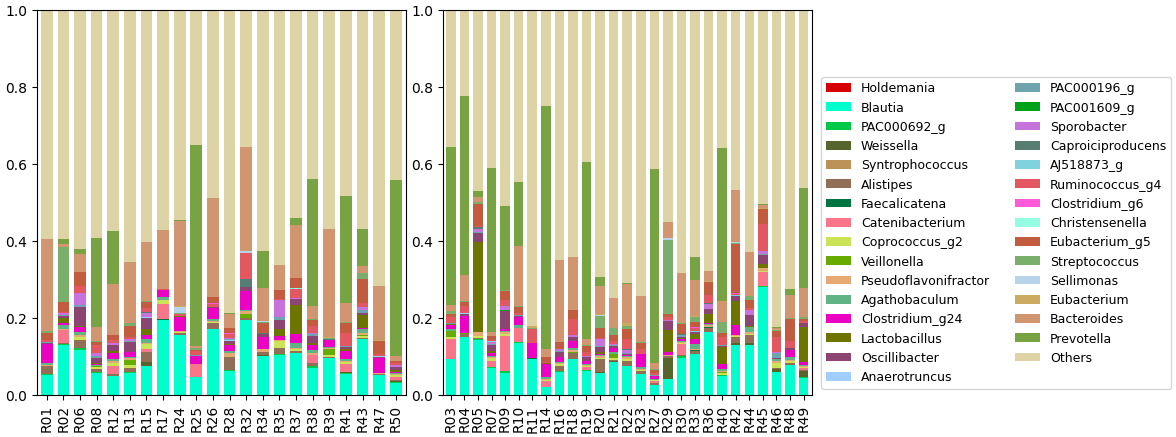

In [76]:
import colorcet as cc

selected_genus = list(collapse_otu(OTU_data[microbiome_col], 6).columns)
selected_genus.append('Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella')
genus = collapse_otu(OTU_data, 6)
genus['Others'] = genus.drop(selected_genus,axis=1).sum(axis=1)
genus = genus[selected_genus+['Others']]

genus.columns = [var.split(';')[-1] for var in genus.columns]
tmp = pd.merge(carb_sensitivity_df,genus,left_on='ID',right_index=True).set_index('ID')
high = tmp.loc[tmp['carb_sen']=='high responder',genus.columns]
low = tmp.loc[tmp['carb_sen']=='low responder',genus.columns]

high_bar = high.div(high.sum(axis=1),axis=0)
low_bar = low.div(low.sum(axis=1),axis=0)

fig,ax = plt.subplots(1,2)
high_bar.plot(kind='bar',stacked=True,figsize=(10,5),width=0.7,colormap=cc.cm.glasbey_light,ax=ax[0])
low_bar.plot(kind='bar',stacked=True,figsize=(10,5),width=0.7,colormap=cc.cm.glasbey_light,ax=ax[1])
ax[0].legend().set_visible(None)
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)

plt.legend(ncols=2, loc='lower center',bbox_to_anchor=(1.5, -0),fontsize = 9)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('../figure/genus_carb_sen.jpeg',dpi=300)
plt.show()

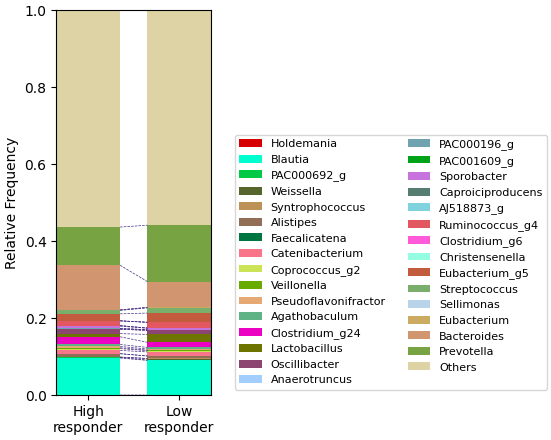

In [83]:
genus_bar = pd.DataFrame([high.sum(),low.sum()],index=['high','low'])
genus_bar = genus_bar.div(genus_bar.sum(axis=1),axis=0)

ax = genus_bar.plot(kind='bar',stacked=True,figsize=(2,5),width=0.7,colormap=cc.cm.glasbey_light)

for i in range(len(genus_bar.columns)):
    h0 = np.sum([genus_bar.iloc[0,k] for k in range(0, i + 1)])
    h1 = np.sum([genus_bar.iloc[1,k] for k in range(0, i + 1)])
    ax.plot([0.7 / 2, 1 - 0.7 / 2],[h0, h1], color='C7', ls='--', zorder=1,linewidth=0.5)

plt.ylim(0,1)
plt.xlim(-0.35,1.35)
plt.ylabel('Relative Frequency')
plt.xticks([0,1],['High\nresponder','Low\nresponder'],rotation=0)
plt.legend(ncols=2, loc='lower right',bbox_to_anchor=(3.2, 0),fontsize = 8)
plt.show()

In [91]:
selected_genus_ = [var.split(';')[-1] for var in selected_genus]
for col in genus.columns:
    res = stats.ttest_ind(high[col],low[col],equal_var=True)
    if res.pvalue<0.05:
        print(col)
        print(res)
        print()

Bacteroides
TtestResult(statistic=2.221374856595797, pvalue=0.03117955207378766, df=47.0)



## Meal composition difference

In [88]:
avg_fiber_list =[]
avg_carb_list =[]
avg_protein_list =[]
avg_fat_list =[]
for sample in samples:
    avg_fiber = full_data[full_data['ID']==sample]['Fiber(g)'].mean()
    avg_carb = full_data[full_data['ID']==sample]['Carb(g)'].mean()
    avg_prot = full_data[full_data['ID']==sample]['Protein(g)'].mean()
    avg_fat = full_data[full_data['ID']==sample]['Fat(g)'].mean()
    avg_fiber_list.append(avg_fiber)
    avg_carb_list.append(avg_carb)
    avg_protein_list.append(avg_prot)
    avg_fat_list.append(avg_fat)


tmp = pd.merge(carb_sensitivity_df,genus,left_on='ID',right_index=True)
tmp['avg_fiber'] = avg_fiber_list
tmp['avg_carb'] = avg_carb_list
tmp['avg_prot'] = avg_protein_list
tmp['avg_fat'] = avg_fat_list
high = tmp.loc[tmp['carb_sen']=='high responder',]
low = tmp.loc[tmp['carb_sen']=='low responder',]
print(stats.ttest_ind(high['avg_fiber'],low['avg_fiber']))
print(stats.ttest_ind(high['avg_carb'],low['avg_carb']))
print(stats.ttest_ind(high['avg_prot'],low['avg_prot']))
print(stats.ttest_ind(high['avg_fat'],low['avg_fat']))

TtestResult(statistic=-2.4800509782731748, pvalue=0.016775979009029832, df=47.0)
TtestResult(statistic=-3.2498920983928485, pvalue=0.002136574122991694, df=47.0)
TtestResult(statistic=-1.923192830636939, pvalue=0.06052591725683312, df=47.0)
TtestResult(statistic=-0.7598046658909383, pvalue=0.4511658401088454, df=47.0)


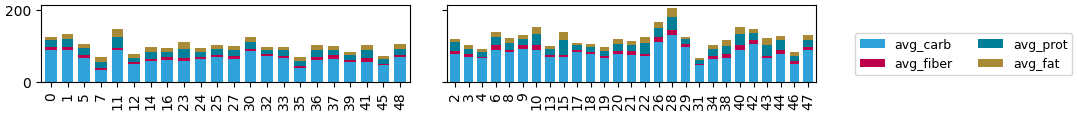

In [89]:
avg_consumption = ['avg_carb','avg_fiber','avg_prot','avg_fat']

fig,ax = plt.subplots(1,2,sharey=True) 
high[avg_consumption].plot(kind='bar',stacked=True,figsize=(10,1),width=0.7,ax=ax[0],colormap=cc.cm.glasbey_hv)
low[avg_consumption].plot(kind='bar',stacked=True,figsize=(10,1),width=0.7,ax=ax[1],colormap=cc.cm.glasbey_hv)

ax[0].legend().set_visible(None)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
plt.legend(ncols=2, loc='lower center',bbox_to_anchor=(1.4, -0),fontsize = 9)
plt.subplots_adjust(wspace=0.1)

(0.0, 210.0)

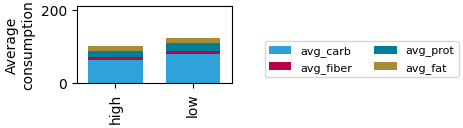

In [90]:
consumption_bar = pd.DataFrame([high[avg_consumption].mean(),low[avg_consumption].mean()],index=['high','low'])

ax = consumption_bar[avg_consumption].plot(kind='bar',stacked=True,figsize=(2,1),width=0.7,colormap=cc.cm.glasbey_hv)
plt.legend(ncols=2, loc='lower right',bbox_to_anchor=(2.5, 0),fontsize = 8)
plt.ylabel('Average\nconsumption')
plt.xlim(-0.5,1.5)
plt.ylim(0,210)

## Correlation network by subgroup

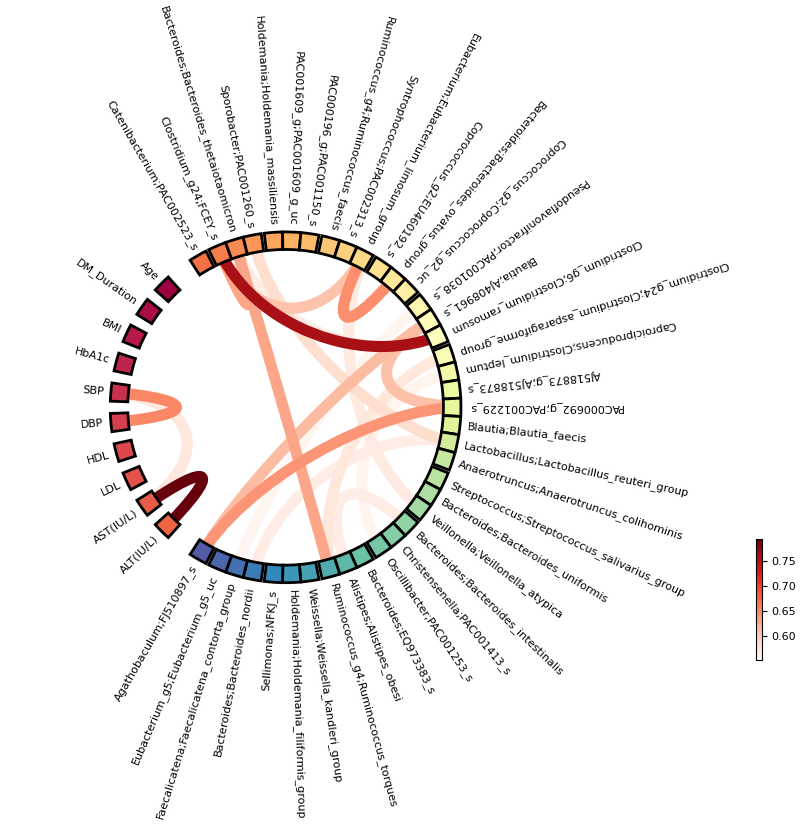

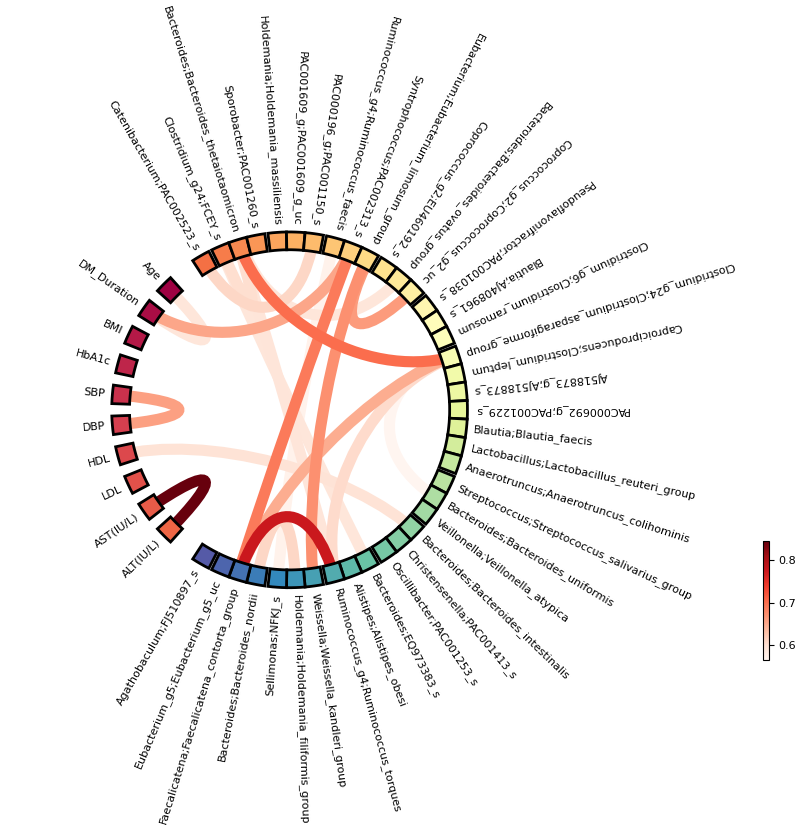

In [317]:
import mne
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle
tmp = pd.merge(OTU_data_bc[microbiome_col_],clinical_data[['ID']+cli_col],left_index=True,right_on='ID').set_index('ID')
tmp = pd.merge(carb_sensitivity_df,tmp,on='ID',how='left')
high = tmp.loc[tmp['carb_sen']=='high responder',cli_col+microbiome_col_]
low = tmp.loc[tmp['carb_sen']=='low responder',cli_col+microbiome_col_]

start, end = 45, 135
first_half = (np.linspace(start, end, len(cli_col)) + 90).astype(int)[::+1] % 360
second_half = (np.linspace(-30, 210, len(microbiome_col_)) - 90).astype(int)[::-1] % 360
node_angles = np.array(list(first_half) + list(second_half))


high_corr = np.where(np.array(high.corr()) > 0.55, np.array(high.corr()), np.nan)
fig, axes = plot_connectivity_circle(high_corr, cli_col+microbiome_col_,node_angles=node_angles,linewidth=8,facecolor='white', textcolor='black',colormap='Reds')

low_corr = np.where(np.array(low.corr()) > 0.55, np.array(low.corr()), np.nan)
fig, axes = plot_connectivity_circle(low_corr, cli_col+microbiome_col_,node_angles=node_angles,linewidth=8,facecolor='white', textcolor='black',colormap='Reds')